In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn import preprocessing
from keras.models import load_model

In [ ]:
df1 = pd.read_csv('/content/Volume.csv',encoding='gbk')
df2 = pd.read_csv('/content/Swing.csv',encoding='gbk')
df3 = pd.read_csv('/content/Turnover.csv',encoding='gbk')
df4 = pd.read_csv('/content/Change_Previous_day.csv',encoding='gbk')
df5 = pd.read_csv('/content/Low.csv',encoding='gbk')
df6 = pd.read_csv('/content/High.csv',encoding='gbk')
df7 = pd.read_csv('/content/Close.csv',encoding='gbk')
df8 = pd.read_csv('/content/Change.csv',encoding='gbk')

In [ ]:
# data
def StockData(i):
    data1 = df1.iloc[i,1:]
    data2 = df2.iloc[i,1:]
    data3 = df3.iloc[i,1:]
    data4 = df4.iloc[i,1:]
    data5 = df5.iloc[i,1:]
    data6 = df6.iloc[i,1:]
    data7 = df7.iloc[i,1:]
    data8 = df8.iloc[i,1:]

    data = pd.DataFrame({  
        'Volume': list(data1),
        'Swing' : list(data2),
        'Turnover': list(data3),
        '% Change(Previous day)': list(data4),
        'Low': list(data5),
        'High': list(data6),
        'Close': list(data7),
        '% Change': list(data8)
    })

    return data


In [ ]:
data = StockData(1)

In [ ]:
data.head()

,Volume,Swing,Turnover,% Change(Previous day),Low,High,Close,% Change
0,960235.0,1.753953,1.025640,1.025640,40.82,40.82,40.64,-0.984252
1,1038380.0,1.747047,1.109108,1.109108,40.80,40.80,40.24,-1.739563
2,1910773.0,2.235338,2.040923,2.040923,39.72,39.72,39.54,1.390996
3,809975.0,1.871523,0.865145,0.865145,40.15,40.15,40.09,-1.322025
4,1157516.0,1.721127,1.236359,1.236359,39.94,39.94,39.56,-0.631951


In [ ]:
# LSTM Models
def LstmModel(name, data, feanum, window, cut, d, epochs, batch_size):
    # Normalization
    min_max_scaler = preprocessing.MinMaxScaler()
    df0 = min_max_scaler.fit_transform(data)
    df = pd.DataFrame(df0, columns=data.columns)
    
    # Process Data, build train set and test set
    stock=df
    seq_len=window
    amount_of_features = len(stock.columns) # Number of columns
    data = stock.values # pd.DataFrame(stock) convert table to matrix
    sequence_length = seq_len + 1 # Sequence length +1
    result = []
    for index in range(len(data) - sequence_length):# Rolling data
        result.append(data[index: index + sequence_length]) # row i to i+5
    result = np.array(result) # Processed data: window * feanum

    # Train set and Test set
    train = result[:-cut, :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[-cut:, :-1]
    y_test = result[-cut:, -1][:,-1]
    X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    # Build LSTM model
    model = Sequential() # build Sequential models
    model.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))
    model.add(Dropout(d)) # Forgotten layer
    model.add(LSTM(16, input_shape=(window, feanum), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(4,kernel_initializer='uniform',activation='relu')) # fully connected layer 
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.fit(X_train, y_train, epochs, batch_size) # fully connected layer 

    model.save("/content/Models/"+str(name)+'.h5')

    # Prediction on the train and test set
    y_test_predict=model.predict(X_test)[:,0]
    mse = (y_test-y_test_predict)**2
    return mse,y_test_predict

In [ ]:
# Run the model
StockNum = df1.shape[0]
StockName = []
PredictReturn = []
mse_list = []
PredictReturn = []

In [ ]:
k = 0 # 0-18
for i in range((k*24),(k+1)*24):
  data = StockData(i)
  mse,predicted = LstmModel(str(i+1),data, feanum=data.shape[1],window=5,cut=1,d=0.0001,epochs=500,batch_size=256)
  StockName.append(i)
  mse_list.append(float(mse))
  PredictReturn.append(float(predicted))

Epoch 1/256
5/5 [==============================] - 0s 5ms/step - loss: 0.3027 - accuracy: 4.1322e-04
Epoch 2/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2962 - accuracy: 4.1322e-04
Epoch 3/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2890 - accuracy: 4.1322e-04
Epoch 4/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2805 - accuracy: 4.1322e-04
Epoch 5/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2697 - accuracy: 4.1322e-04
Epoch 6/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2547 - accuracy: 4.1322e-04
Epoch 7/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2336 - accuracy: 4.1322e-04
Epoch 8/256
5/5 [==============================] - 0s 5ms/step - loss: 0.2056 - accuracy: 4.1322e-04
Epoch 9/256
5/5 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 4.1322e-04
Epoch 10/256
5/5 [==============================] - 0s 5ms/step - loss: 0.1364 - accuracy: 

IndexError: ignored

In [ ]:
sum(mse_list)/len(mse_list)

0.052607271059458255

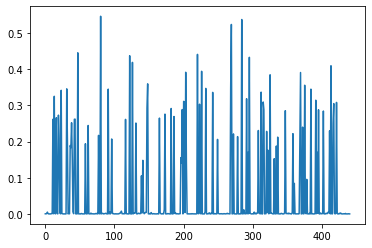

In [ ]:
# MSE
import matplotlib.pyplot as plt
plt.plot(mse_list)

In [ ]:
# concat data
n = df8.shape[1]
real = df8.iloc[:,(n-1)]
real_data = pd.DataFrame(real)
min_max_scaler = preprocessing.MinMaxScaler()
real_data = min_max_scaler.fit_transform(real_data)
real_list = []
for i in list(real_data):
  real_list.append(float(i))
result = pd.DataFrame({  
        'Number': [i+1 for i in list(StockName)],
        'Predicted % Change ': PredictReturn,
        'Real % Change': real_list,
        "MSE": mse_list
    })

In [6]:
import pandas as pd
result = pd.read_csv('/content/result.csv',encoding='gbk')
result.head()

,Stock Name,Number,Predicted % Change,Real % Change,MSE
0,A.N,1,0.486408,0.491757,0.000337
1,AAP.N,2,0.553262,0.393687,0.000248
2,AAPL.O,3,0.586246,0.615013,0.000909
3,ABC.N,4,0.580272,0.437057,0.004956
4,ABMD.O,5,0.520636,0.347396,0.000833


In [ ]:
# Save models
import os, tarfile
import os
from google.colab import files
def make_targz_one_by_one(output_filename, source_dir):
  tar = tarfile.open(output_filename,"w")
  for root,dir_name,files_list in os.walk(source_dir):
    for file in files_list:
      pathfile = os.path.join(root, file)
      tar.add(pathfile)
  tar.close()
 
  files.download(output_filename)
make_targz_one_by_one('AllModels.tar', '/content/Models')